Source
-- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
import math
import numpy as np
import matplotlib.pyplot as plt
# from cnnDataset import CNNDataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device,  torch.cuda.is_available() 

(device(type='cuda'), True)

In [36]:
resizer = 1
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize([2*64*resizer, 2*64*resizer]), # This line
                               torchvision.transforms.Normalize((.5,.5,.5), (.5,.5,.5))
                                ])
# load dataset 
# csv_path = 'C:\\Users\\amart50\\Desktop\\CNN_test\\cnn_name_class.csv'
# data_path = 'C:\\Users\\amart50\\Desktop\\CNN_test\\Data_Cnn'

# dataset = CNNDataset(csv_file='cnn_name_class.csv', root_dir='Data_cnn', transform=transform)

In [37]:
data_path = 'C:\\Users\\mkingsl6\\Desktop\\ViTPose\\298_scripts\\CNN_test\\data'
dataset = ImageFolder(data_path, transform=transform)

In [38]:
batch_size = 3
train_split = int( len(dataset) * .8)
test_split = len(dataset)- train_split
print(train_split, test_split, train_split+test_split, len(dataset))

840 210 1050 1050


In [39]:

train_set, test_set = torch.utils.data.random_split(dataset, [train_split, test_split])
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [40]:
# dataset.__getitem__(0)
dataset.classes, trainloader, testloader

(['Bench', 'Deadlift', 'Squat'],
 <torch.utils.data.dataloader.DataLoader at 0x2d84ea00e80>)

In [41]:
img, label = next(iter(trainloader))
print(f"Image Shape:{img.shape} (B, colorchannel, H, W)")
print(f"Image Shape:{label.shape} (B, colorchannel, H, W)")

Image Shape:torch.Size([3, 3, 128, 128]) (B, colorchannel, H, W)
Image Shape:torch.Size([3]) (B, colorchannel, H, W)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


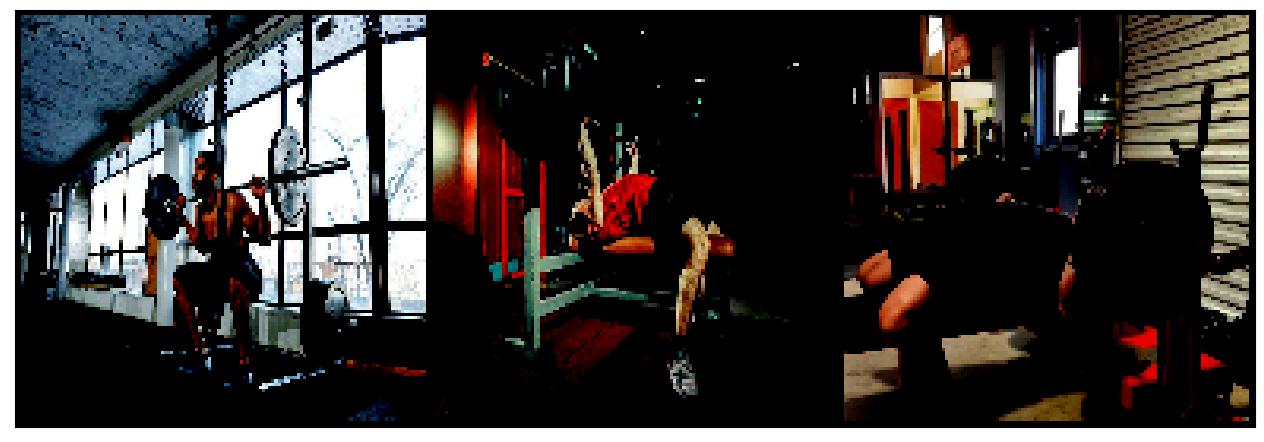

In [42]:
# grid_img = torchvision.utils.make_grid(images[:4])
# import matplotlib.pyplot as plt
# plt.imshow(grid_img.permute(1, 2, 0))
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(trainloader)

In [43]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) 

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc 
     

In [44]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc
     

In [45]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

In [100]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=2* hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=2* hidden_units,
                  out_channels=4* hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=4* hidden_units,
                  out_channels=16*hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16*hidden_units,
                  out_channels=32*2*hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.MaxPool2d(kernel_size=2)
    )


    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=32*2* hidden_units,
                  out_channels=4*2* hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=4*2*hidden_units,
                  out_channels=4*hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.MaxPool2d(kernel_size=2)
    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*(16*2)*(16*2),
                  out_features=output_shape))
        
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.conv_block_3(x)

    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

In [101]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=16*4,
                  output_shape=len(dataset.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(1024, 4096, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(4096, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padd

In [102]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 2*64, 2*64])
model_0(dummy_x.to(device))

tensor([[-0.0024, -0.0011, -0.0030]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [103]:
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9)


In [104]:
model_0_results = train(model=model_0,
                        train_dataloader=trainloader,
                        test_dataloader=testloader,
                        optimizer=optimizer,
                        epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]